In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
from utils.pluto_utils import PlutoData
from utils.visualise import *

In [3]:
import yt
import soxs
import pyxsim

soxs : [WARNING  ] 2025-05-15 12:05:31,491 Setting 'soxs_data_dir' to /home/yangelaxue/.cache/soxs for this session. Please update your configuration if you want it somewhere else.


# Units

In [4]:
CONST_kB = 1.380649e-16 # ergs/K
CONST_thompson = 6.6524587158e-25 # cm^2
CONST_me = 9.10938356e-28 # gr
CONST_erg_to_eV = 6.242e+11
CONST_c = 3e10 # cm/s

# Load Data

In [5]:
output_dir = "/home/yangelaxue/Documents/VUW/pluto_runs/HD/Blast/"
save_dir = os.path.join(output_dir,'visualisation/')

if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [6]:
data = PlutoData(output_dir)
data.__dict__

{'output_dir': '/home/yangelaxue/Documents/VUW/pluto_runs/HD/Blast/',
 'ndim': 3,
 'Units': <utils.pluto_utils.PlutoUnits at 0x788e11db6cf0>}

In [7]:
units = 'physical'
timeslices = 'all'

In [8]:
if data.ndim==2:
    X, Y = data.load_domain_from_HDF5(units=units)
elif data.ndim==3:
    X, Y, Z = data.load_domain_from_HDF5(units=units)
times = data.load_times(units=units)

In [9]:
rho = data.load_data_from_HDF5('rho',units=units,timeslices=timeslices)

In [10]:
vx1 = data.load_data_from_HDF5('vx1',units=units,timeslices=timeslices)
vx2 = data.load_data_from_HDF5('vx2',units=units,timeslices=timeslices)

if data.ndim==2:
    v = [(_vx1**2 + _vx2**2)**.5 for _vx1,_vx2 in zip(vx1,vx2)]
elif data.ndim>2:
    vx3 = data.load_data_from_HDF5('vx3',units=units,timeslices=timeslices)
    v = [(_vx1**2 + _vx2**2 + _vx3**2)**.5 for _vx1,_vx2,_vx3 in zip(vx1,vx2,vx3)]

In [11]:
try:
    prs = data.load_data_from_HDF5('prs',units=units,timeslices=timeslices)
    prs_bool = True
except:
    prs_bool = False
    print("Pressure is not part of the simulation.")

In [12]:
try:
    Bx1 = data.load_data_from_HDF5('Bx1',units=units,timeslices=timeslices)
    Bx2 = data.load_data_from_HDF5('Bx2',units=units,timeslices=timeslices)
    
    if data.ndim==2:
        B = [(_Bx1**2 + _Bx2**2)**.5 for _Bx1,_Bx2 in zip(Bx1,Bx2)]
    elif data.ndim>2:
        Bx3 = data.load_data_from_HDF5('Bx3',units=units,timeslices=timeslices)
        B = [(_Bx1**2 + _Bx2**2 + _Bx3**2)**.5 for _Bx1,_Bx2,_Bx3 in zip(Bx1,Bx2,Bx3)]
    B_bool = True
except:
    B_bool = False
    print("Magnetism is not part of the simulation.")

Magnetism is not part of the simulation.


# PLOTS

In [13]:
XY = (X[0],Y[0]) if X.ndim==3 else (X,Y)
_X, _Y = XY

# Compton-y

In [14]:
from scipy.integrate import simpson

In [15]:
dx = np.median(np.diff(X[0,0])*data.Units.L_0)

In [16]:
out = CONST_thompson/(CONST_me*CONST_c**2) * np.array([simpson(_prs, dx=dx, axis=2) for _prs in prs])

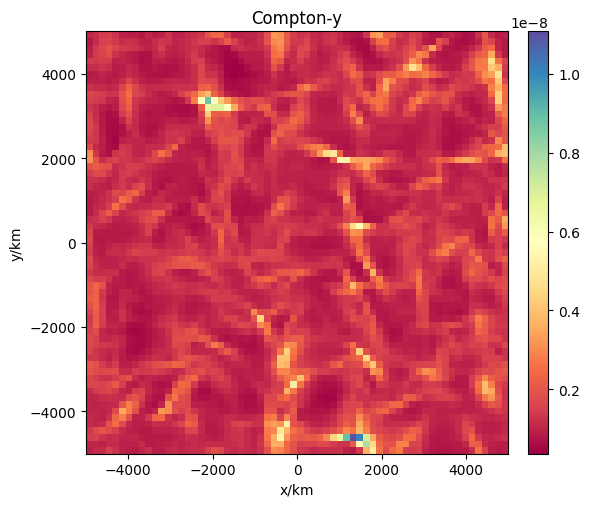

In [17]:
fig, ax = plt.subplots(1,1,figsize=(6,6),tight_layout=True)

ax.set_aspect('equal')
ax.set_xlabel('x/km')
ax.set_ylabel('y/km')
ax.set_title('Compton-y')

im = ax.pcolormesh(_X/1e5,_Y/1e5,out[-1],cmap='Spectral')

cbar = get_cbar(im, fig, ax)




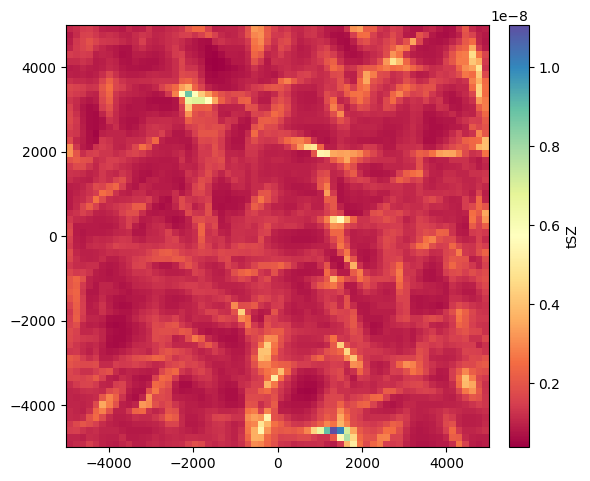

In [18]:
_var_list = get_list2D(out, 32)
_var_list = np.array(_var_list) # Temperature in ergs
var_name = 'comptony'

vmin, vmax = np.min(_var_list), np.max(_var_list)

animate_vars(_var_list,save_dir=os.path.join(save_dir,f'{var_name}.mp4'),title=f'{var_name}',
             XY=(_X/1e5,_Y/1e5),
            x_label='x/km',
            y_label='y/km',
            vmin=vmin,vmax=vmax,
            cmap='Spectral',
            cbar_label='tSZ'
)

In [19]:
L = (X.max()-X.min())*65/64

In [26]:
10000000

10000000

In [24]:
L/(data.Units.CONST_pc*10**6)

3.2399880054001e-16

In [27]:
cluster_L = data.Units.CONST_pc*10**6 # cm

In [30]:
L/cluster_L

3.2399880054001e-16

In [30]:
T = np.array([_prs*CONST_me/_rho for _prs,_rho in zip(prs,rho)])

In [32]:
T_mean = [_T.mean() for _T in T]

Text(0.5, 0, 'Temperature (eV?)')

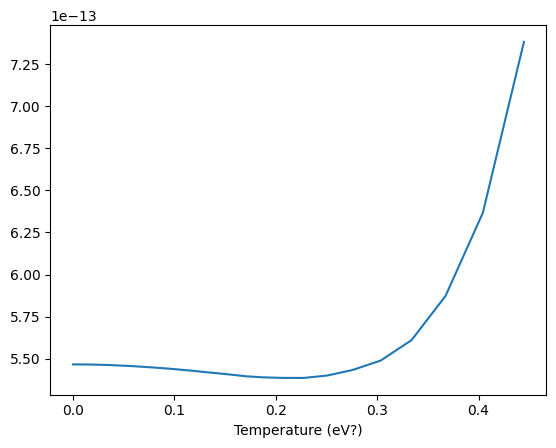

In [34]:
plt.plot(times,T_mean)
plt.xlabel('time (s)')
plt.xlabel('Temperature (eV?)')

# Mach Number

In [29]:
v_rms = np.sqrt(np.mean(np.power(v,2),axis=(1,2,3)))

In [42]:
gamma = 5/3

c_s = np.sqrt(gamma*np.mean(prs,axis=(1,2,3))/np.mean(rho,axis=(1,2,3)))

In [43]:
Mach = v_rms/c_s

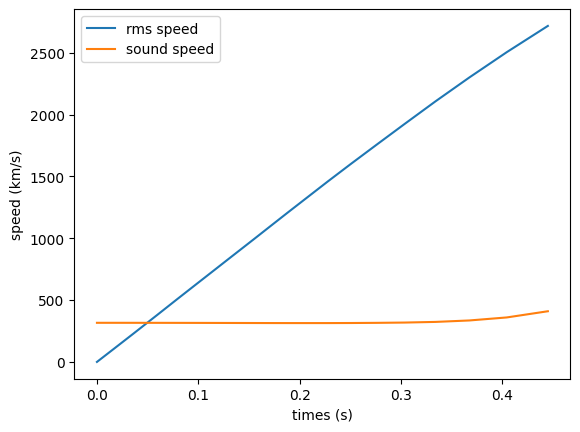

In [46]:
plt.plot(times,v_rms/1e5, label='rms speed')
plt.plot(times,c_s/1e5, label='sound speed')
plt.xlabel('times (s)')
plt.ylabel('speed (km/s)')

plt.legend()

plt.show()

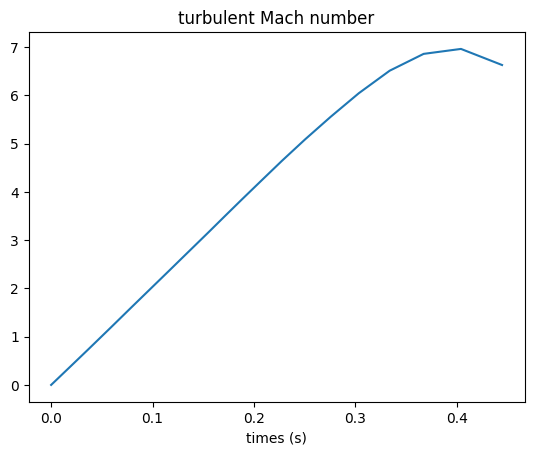

In [47]:
plt.plot(times,Mach)
plt.xlabel('times (s)')

plt.title('turbulent Mach number')

plt.show()

In [62]:
prs_mean = np.mean(prs,axis=(1,2,3))
prs_del = [_prs-_prs_mean for _prs,_prs_mean in zip(prs,prs_mean)]
prs_rms = np.sqrt(np.mean(np.power(prs_del,2),axis=(1,2,3)))

# prs_rms = np.sqrt(np.mean(np.power(prs-np.mean(prs,axis=(1,2,3)),2),axis=(1,2,3)))
# rho_rms = np.sqrt(np.mean(np.power(rho-np.mean(rho,axis=(1,2,3)),2),axis=(1,2,3)))

In [73]:
prs_rms/prs_mean

array([3.29694239e-16, 2.67589354e-04, 1.08248580e-03, 2.95337486e-03,
       5.37126061e-03, 7.95689715e-03, 1.19948782e-02, 1.49033404e-02,
       2.34580769e-02, 3.01679468e-02, 3.93116579e-02, 5.23105992e-02,
       7.16894126e-02, 1.01263609e-01, 1.47253655e-01, 2.23110240e-01,
       3.56980189e-01, 6.14366096e-01, 1.11078311e+00, 1.83148234e+00])

In [1]:
plt.scatter(Mach, prs_rms/prs_mean, label='prs rms')
# plt.scatter(Mach, rho_rms, label='rho rms')

plt.yscale('log')
plt.xscale('log')

# plt.gca().set_aspect('equal')
# plt.xlim(0.3, 10)
# plt.ylim(0.3, 10)

plt.xlabel('Mach')

NameError: name 'plt' is not defined

In [75]:
Mach

array([0.        , 0.36528575, 0.73237452, 1.19773506, 1.6078378 ,
       1.95168675, 2.3677677 , 2.6088327 , 3.16422303, 3.48829293,
       3.84223774, 4.22617234, 4.6466566 , 5.09149196, 5.558365  ,
       6.04569138, 6.51249223, 6.86128449, 6.96398106, 6.63047838])